In [96]:
from sage.sets.family import Family
from sage.rings.rational_field import QQ
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.misc.cachefunc import cached_method
from sage.matrix.constructor import matrix
from sage.combinat.symmetric_group_algebra import e
from sage.combinat.permutation import Permutation
from sage.combinat.partition import Partition
from sage.combinat.diagram import Diagram
from sage.categories.modules_with_basis import ModulesWithBasis
from sympy.polys.matrices import DomainMatrix
from sympy.physics.quantum.matrixutils import matrix_tensor_product
from sympy.parsing.sympy_parser import parse_expr
from sympy import Matrix, SparseMatrix, eye
import matplotlib.pyplot as plt
import numpy
import os.path
import json
import itertools
import networkx as nx
Symqt = SymmetricFunctions(QQ)
s = Symqt.s()
sp = Symqt.sp()
e = Symqt.e()
p = Symqt.p()

In [97]:
from sage.categories.modules_with_basis import ModulesWithBasis
from sage.combinat.diagram import Diagram
from sage.combinat.partition import Partition
from sage.combinat.permutation import Permutation
from sage.combinat.symmetric_group_algebra import e
from sage.matrix.constructor import matrix
from sage.misc.cachefunc import cached_method
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.rings.rational_field import QQ
from sage.sets.family import Family

import random


class SpechtModuleWithBasis(SubmoduleWithBasis):
    @staticmethod
    def __classcall_private__(cls, SGA, D):
        D = _to_diagram(D)
        D = Diagram(D)
        n = len(D)
        if SGA.group().rank() != n - 1:
            rk = SGA.group().rank() + 1
            raise ValueError(
                f"the domain size (={rk}) does not match the number of boxes (={n}) of the diagram")
        return super().__classcall__(cls, SGA, D)

    def __init__(self, SGA, D):
        self._diagram = D
        Mod = ModulesWithBasis(SGA.category().base_ring())
        span_set = specht_module_spanning_set(D, SGA)
        support_order = SGA.get_order()
        basis = SGA.echelon_form(span_set, False, order=support_order)
        basis = Family(basis)
        SubmoduleWithBasis.__init__(self, basis, support_order, ambient=SGA,
                                    unitriangular=False, category=Mod.Subobjects())

    def _re_basis_representation_matrix(self, elt):
        SGA = self._ambient
        return matrix(self.base_ring(), [self.retract(SGA(elt) * b.lift()).to_vector()
                                         for b in self.basis()]).T

    def representation_matrix(self, elt):
        cob_matrix = matrix(self.base_ring(), [self.retract(permutation_for_tableau(standard_tableau)).to_vector()
                                               for standard_tableau in _to_partition(self._diagram).standard_tableaux()])

        return cob_matrix * self._re_basis_representation_matrix(elt) * cob_matrix.inverse()

    class Element(SubmoduleWithBasis.Element):
        def _acted_upon_(self, x, self_on_left=False):
            # Check for a scalar first
            ret = super()._acted_upon_(x, self_on_left)
            if ret is not None:
                return ret
            # Check if it is in the symmetric group algebra
            P = self.parent()
            if x in P._ambient or x in P._ambient.group():
                if self_on_left:  # it is only a left module
                    return None
                else:
                    return P.retract(P._ambient(x) * self.lift())
            return None


def _to_partition(D):
    list_for_partition = []

    for box in D:
        if box[0] >= len(list_for_partition):
            list_for_partition.append(0)

        list_for_partition[box[0]] += 1

    return Partition(list_for_partition)


def _to_diagram(D):
    from sage.combinat.integer_vector import IntegerVectors
    from sage.combinat.partition import _Partitions
    from sage.combinat.skew_partition import SkewPartitions
    if isinstance(D, Diagram):
        return D
    if D in _Partitions:
        D = _Partitions(D).cells()
    elif D in SkewPartitions():
        D = SkewPartitions()(D).cells()
    elif D in IntegerVectors():
        cells = []
        for i, row in enumerate(D):
            for j in range(row):
                cells.append((i, j))
        D = cells
    else:
        D = [tuple(cell) for cell in D]
    return D


def permutation_for_tableau(tableau):
    reference_tableau = Partition(tableau.shape()).standard_tableaux()[0]
    symmetrizer = e(reference_tableau)
    return Permutation(tableau.reading_word_permutation().inverse().to_cycles()) * Permutation(reference_tableau.reading_word_permutation().to_cycles()) * symmetrizer


def specht_module_spanning_set(D, SGA=None):
    return [permutation_for_tableau(standard_tableau) for standard_tableau in _to_partition(D).standard_tableaux()]

In [53]:
def standard_basis(n):
    # Create the standard basis for an n-dimensional vector space
    basis = []

    n = Integer(n)

    for i in range(n):
        basis_element = SparseMatrix(Matrix([0] * n))
        basis_element[i] = 1
        basis.append(basis_element)

    return basis

In [54]:
def tensor(obs):
    # Return the n-fold tensor product of some objects

    n = len(obs)

    if n == 1:
        return obs[0]

    a = obs[0]
    b = tensor(obs[1:])

    return matrix_tensor_product(a, b)

In [55]:
def direct_sum_basis(bases):
    if len(bases) == 1:
        return bases[0]

    A = bases[0]
    B = direct_sum_basis(bases[1:])

    basis = []

    for a in A:
        basis.append(a.col_join(SparseMatrix(Matrix([0] * B[0].shape[0]))))
    for b in B:
        basis.append(SparseMatrix(Matrix([0] * A[0].shape[0])).col_join(b))

    return basis

In [56]:
def tensor_basis(bases):
    if len(bases) == 1:
        return bases[0]

    basis = []

    for a in bases[0]:
        for b in tensor_basis(bases[1:]):
            basis.append(tensor([a, b]))

    return basis

In [57]:
class MinimizedRepresentation:
    def __init__(self, information):
        self.information = information

    def multiply_by(irriducible, represenation):
        new_information = {}

        for rho in represenation.information:
            for irriducible_sub_rep, multiplicty in s[list(irriducible.information.keys())[0]] * s[rho]:
                subspace = tensor_basis(
                    [represenation.information[rho], standard_basis(multiplicty)])

                if irriducible_sub_rep in new_information:
                    new_information[irriducible_sub_rep] = direct_sum_basis(
                        [new_information[irriducible_sub_rep], subspace])
                else:
                    new_information[irriducible_sub_rep] = subspace

        maps = {}
        dimensions = {rho: [0, len(new_information[rho])] for rho in new_information}

        for rho in represenation.information:
            for irriducible_sub_rep, multiplicty in s[list(irriducible.information.keys())[0]] * s[rho]:
                multiplicty *= len(represenation.information[rho])
                dimensions[irriducible_sub_rep][1] -= multiplicty
                width = new_information[irriducible_sub_rep]

                maps[(rho, irriducible_sub_rep)] = SparseMatrix(dimensions[irriducible_sub_rep][0], multiplicty, [0] * int(dimensions[irriducible_sub_rep][0] * multiplicty)).col_join(
                    SparseMatrix(eye(multiplicty))).col_join(
                    SparseMatrix(dimensions[irriducible_sub_rep][1], multiplicty,  [0] * int(dimensions[irriducible_sub_rep][1] * multiplicty)))

                dimensions[irriducible_sub_rep][0] += multiplicty

        return MinimizedRepresentation(new_information), maps

    def num_irriducibles(self):
        return len(self.information)

In [58]:
class GradedAlgebraRepresentation:
    def __init__(self, information, max_degree):
        # The highest degree this algebra is calculated to
        self.max_degree = max_degree
        # The underlying symplectic representations sorted by degree
        self.information = information

In [59]:
class GradedEndormorphism:
    def __init__(self, information, degree, gar):
        self.information = information
        self.degree = degree
        self.gar = gar

    def plot(self, latex, size=(10, 10)):
        def internal_label(degree, weight):
            return (f'd{degree}w' + f'{weight}'[1:-1]).replace(' ', '').replace(',', 'c')

        def external_label(weight, dimension):
            return '$H^{' + f'{dimension}' + '}_{' + f'{weight}'[1:-1] + '}$'

        G = nx.DiGraph()
        labels = {}

        h = self.gar.information[max(self.gar.information.keys())].num_irriducibles() * 1.5

        for k in self.gar.information.keys():
            for i, weight in enumerate(self.gar.information[k].information):
                G.add_node(internal_label(k, weight), pos=(
                    float((i + 1 / 2.0) * h / self.gar.information[k].num_irriducibles()), (float(k) - 1) * 2))
                labels[internal_label(k, weight)] = external_label(
                    weight, len(self.gar.information[k].information[weight]))

            if k in self.information:
                for nonzero_map in self.information[k]:
                    G.add_edge(internal_label(k, nonzero_map[0]),
                               internal_label(k + 1, nonzero_map[1]))

        plt.figure(figsize=size)
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw(G, pos, node_color='#fabfff')
        nx.draw_networkx_labels(G, pos, labels, font_size=12)

        if latex:
            print(nx.to_latex(G, pos, node_label=labels))

    def difference(a, b):
        # We assume that a and b have a
        difference_information = {}

        for k in a.information:
            difference_information[k] = {}
            for key in a.information[k]:
                difference_of_maps = a.information[k][key] - b.information[k][key]
                if difference_of_maps.rank() != 0:
                    difference_information[k][key] = difference_of_maps

        return GradedEndormorphism(difference_information, 1, a.gar)

    def ideal_generated_by(self):
        pass  # TODO: This

In [60]:
def create_tensor_representation_algebra(represenation, n):
    tensor_algebra = GradedAlgebraRepresentation({1: represenation}, 1)
    left_multiplication = GradedEndormorphism({}, 0, tensor_algebra)

    for k in range(1, n):
        tensor_algebra_information = tensor_algebra.information
        left_multiplication_information = left_multiplication.information

        tensor_algebra_information[k + 1], left_multiplication_information[k] = MinimizedRepresentation.multiply_by(
            represenation, tensor_algebra_information[k])

        tensor_algebra = GradedAlgebraRepresentation(tensor_algebra_information, k + 1)
        left_multiplication = GradedEndormorphism(
            left_multiplication_information, 1, tensor_algebra)

    return tensor_algebra, left_multiplication

In [61]:
base_representation = MinimizedRepresentation({(1,): standard_basis(1)})
tensor_algebra, left_multiplication = create_tensor_representation_algebra(base_representation, 4)

\documentclass{report}
\usepackage{tikz}
\usepackage{subcaption}

\begin{document}
\begin{figure}
  \begin{tikzpicture}
      \draw
        (3.75, 0.0) node (d1w1c){$H^{1}_{1,}$}
        (1.875, 2.0) node (d2w1c1){$H^{1}_{1, 1}$}
        (5.625, 2.0) node (d2w2){$H^{1}_{2}$}
        (1.25, 4.0) node (d3w2c1){$H^{2}_{2, 1}$}
        (3.75, 4.0) node (d3w1c1c1){$H^{1}_{1, 1, 1}$}
        (6.25, 4.0) node (d3w3){$H^{1}_{3}$}
        (0.75, 6.0) node (d4w2c1c1){$H^{3}_{2, 1, 1}$}
        (2.25, 6.0) node (d4w2c2){$H^{2}_{2, 2}$}
        (3.75, 6.0) node (d4w3c1){$H^{3}_{3, 1}$}
        (5.25, 6.0) node (d4w1c1c1c1){$H^{1}_{1, 1, 1, 1}$}
        (6.75, 6.0) node (d4w4){$H^{1}_{4}$};
      \begin{scope}[->]
        \draw (d1w1c) to (d2w1c1);
        \draw (d1w1c) to (d2w2);
        \draw (d2w1c1) to (d3w2c1);
        \draw (d2w1c1) to (d3w1c1c1);
        \draw (d2w2) to (d3w2c1);
        \draw (d2w2) to (d3w3);
        \draw (d3w2c1) to (d4w2c1c1);
        \draw (d3w2c1) to (d4w2c2);
       

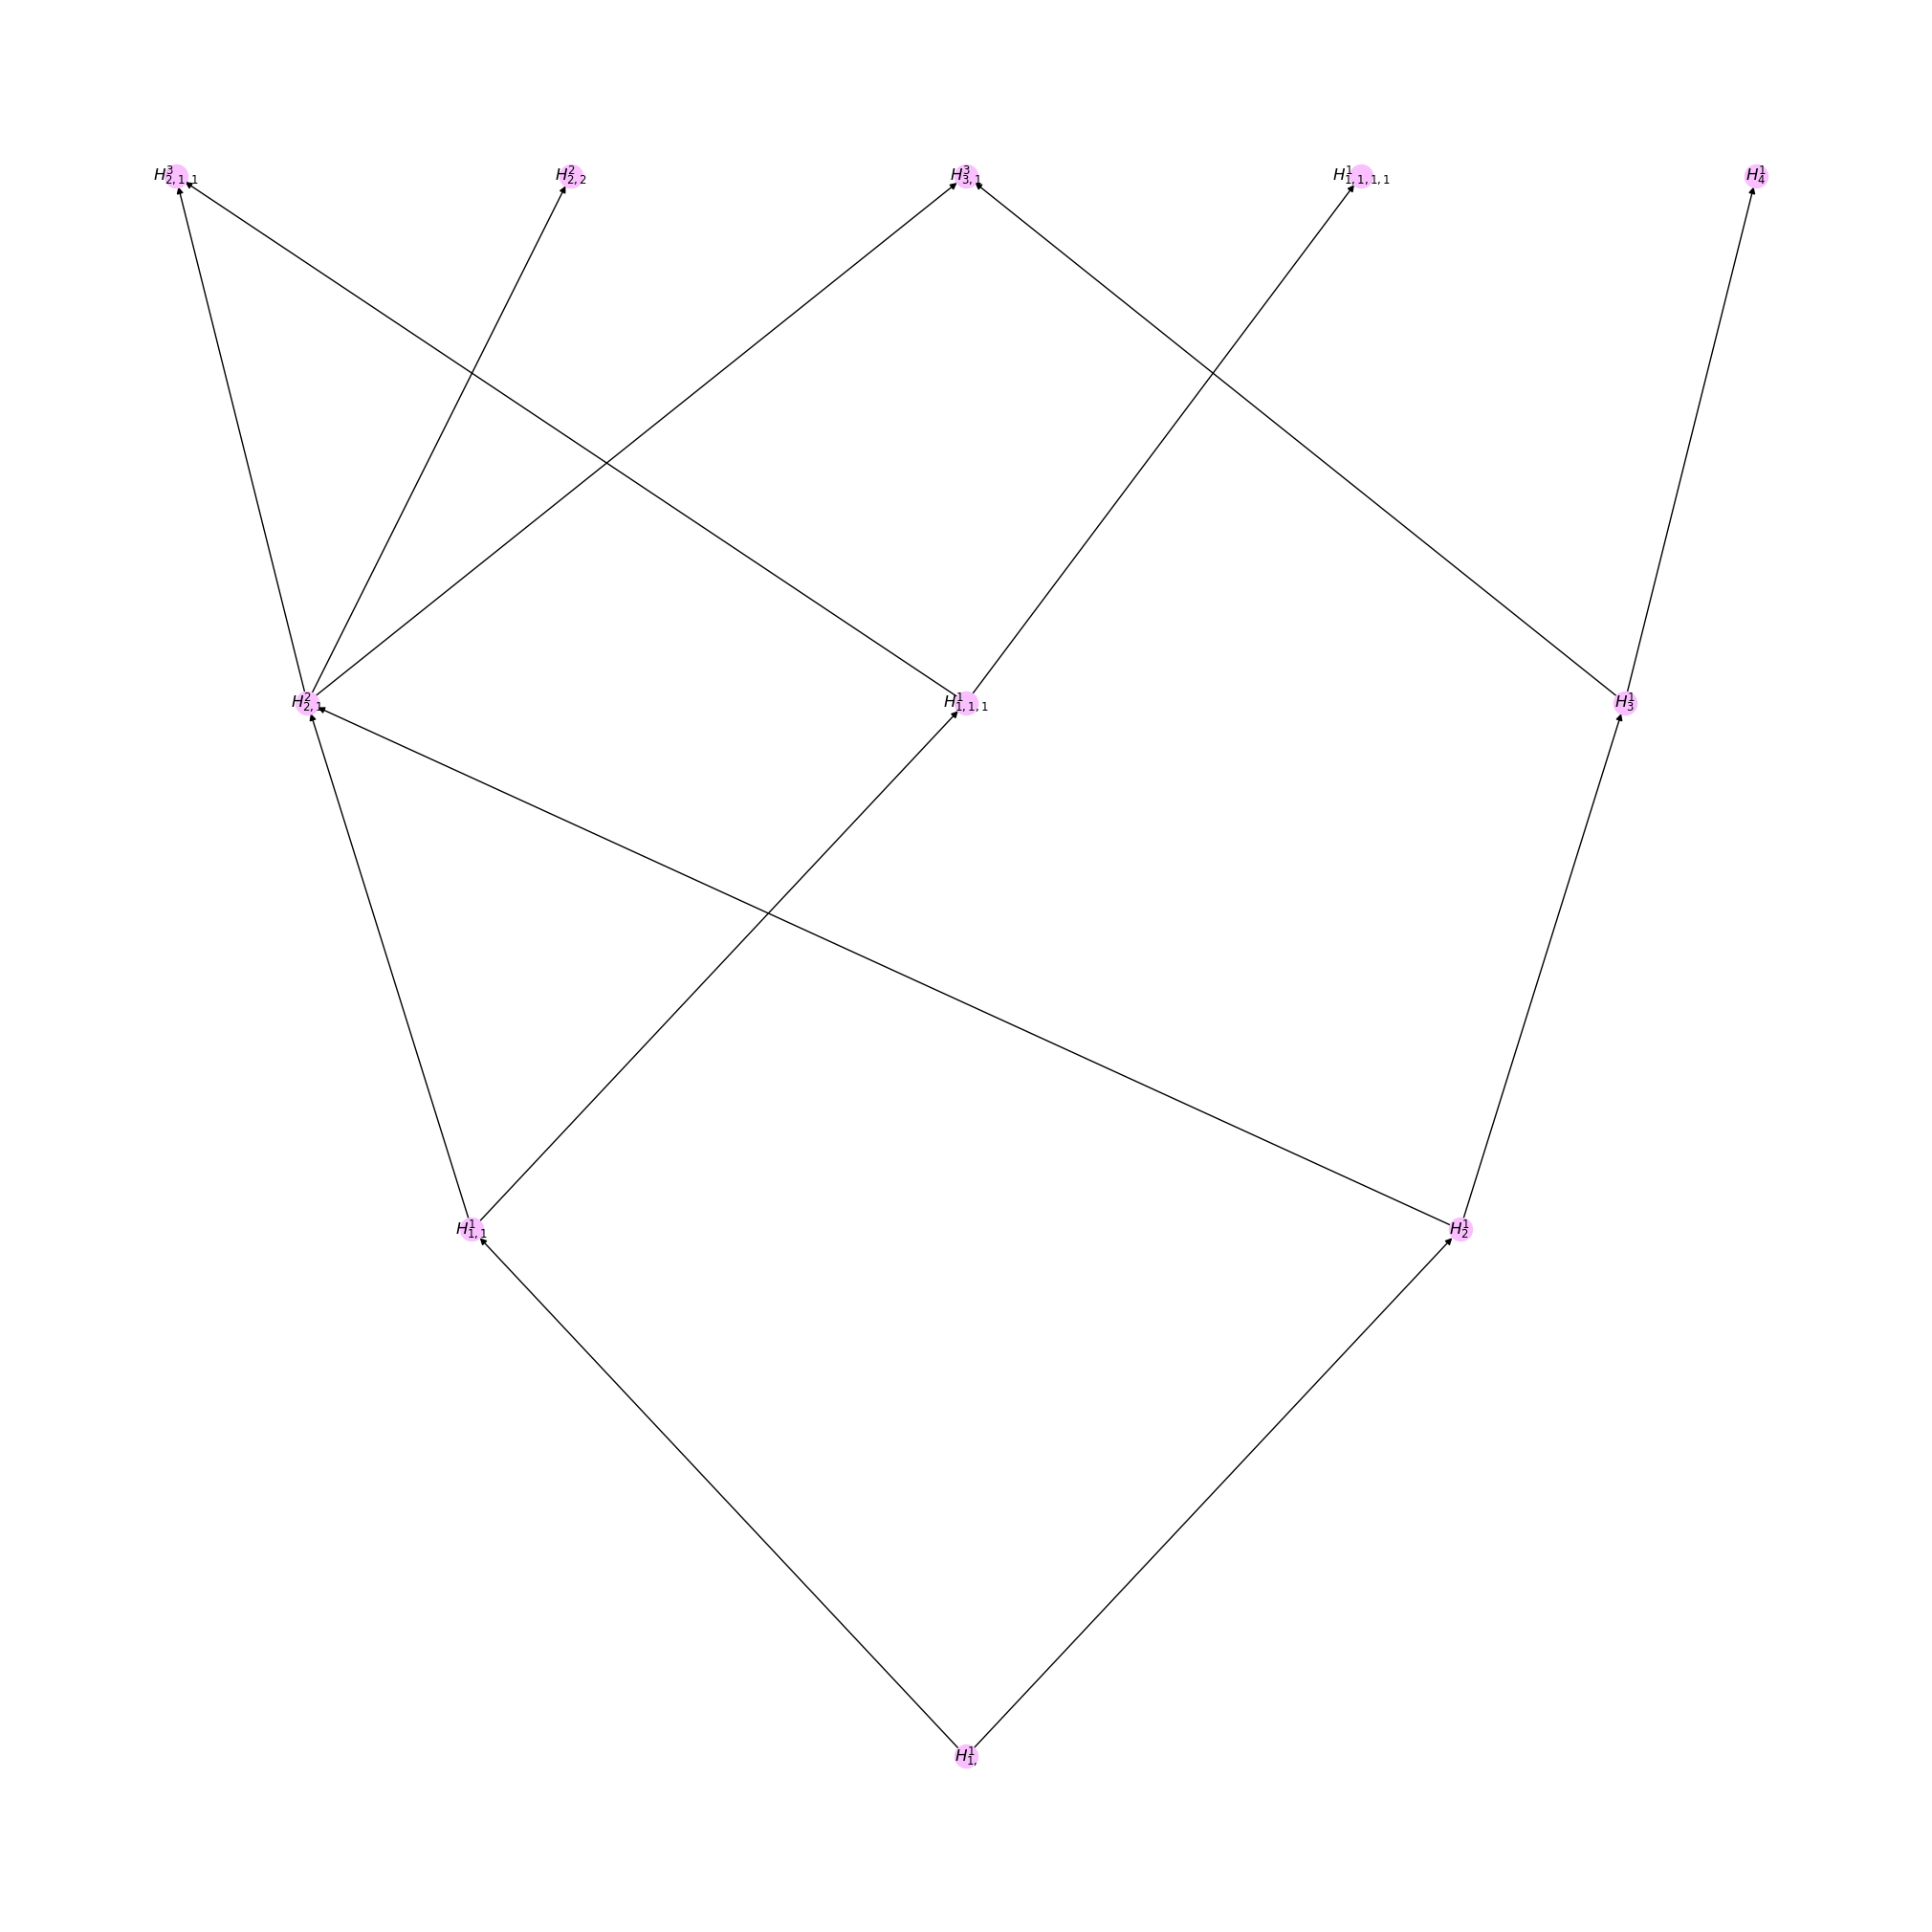

In [62]:
left_multiplication.plot(true, (20, 20))

In [63]:
def reverse_permutation(n):
    return Permutation(list(range(1, n + 1))[::-1])


def action_of_reverse(weight):
    # TODO:  This needs some cleaning up
    sm = SpechtModuleWithBasis(SymmetricGroupAlgebra(QQ, sum(weight)), Partition(weight))
    action = sm.representation_matrix(reverse_permutation(sum(weight)))
    return SparseMatrix(action.numpy()).T

In [64]:
def derive_right_multiplication(left_multiplication):
    # TODO:  This needs some cleaning up
    gar = left_multiplication.gar

    reverse_actions = {}

    for k in gar.information.keys():
        for weight in gar.information[k].information:
            reverse_actions[weight] = action_of_reverse(weight)

    right_multiplication_information = {}

    for k in left_multiplication.information.keys():
        right_multiplication_information[k] = {}

        for start, end in left_multiplication.information[k].keys():
            right_multiplication_information[k][(
                start, end)] = reverse_actions[end] @ left_multiplication.information[k][(start, end)] @ reverse_actions[start]

    return GradedEndormorphism(right_multiplication_information, 1, gar)

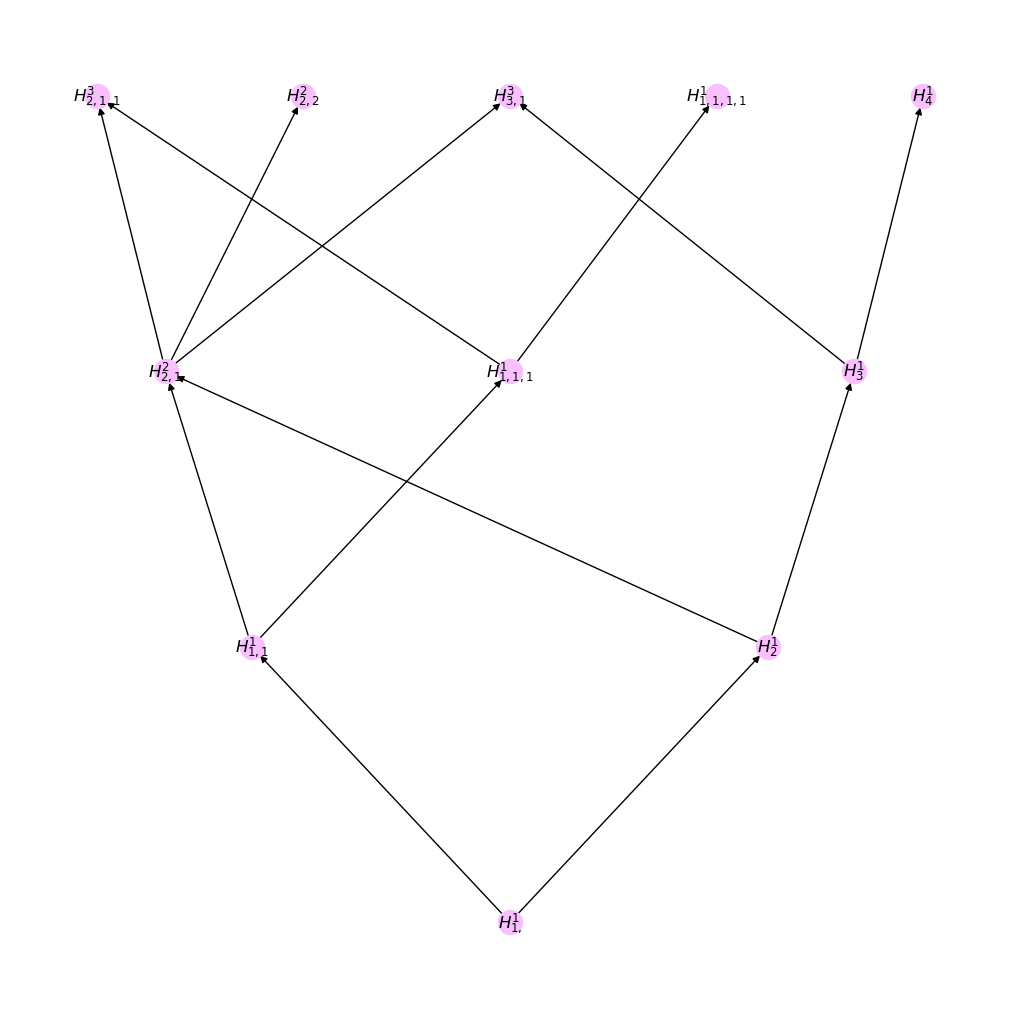

In [65]:
right_multiplication = derive_right_multiplication(left_multiplication)
right_multiplication.plot(false)

In [66]:
def free_lie_algebra(represenation, n):
    tensor_algebra, left_multiplication = create_tensor_representation_algebra(represenation, n)
    right_multiplication = derive_right_multiplication(left_multiplication)

    bracket = GradedEndormorphism.difference(left_multiplication, right_multiplication)

    bracket.plot(false)

In [67]:
free_lie_algebra(base_representation, 5)

ValueError: [1, 2, 3, 4, 5] - [1, 2, 3, 5, 4] - [1, 2, 4, 3, 5] + [1, 2, 4, 5, 3] + [1, 2, 5, 3, 4] - [1, 2, 5, 4, 3] + [1, 5, 2, 3, 4] - [1, 5, 2, 4, 3] - [1, 5, 3, 2, 4] + [1, 5, 3, 4, 2] + [1, 5, 4, 2, 3] - [1, 5, 4, 3, 2] - [2, 1, 3, 4, 5] + [2, 1, 3, 5, 4] + [2, 1, 4, 3, 5] - [2, 1, 4, 5, 3] - [2, 1, 5, 3, 4] + [2, 1, 5, 4, 3] + [2, 4, 1, 3, 5] - [2, 4, 1, 5, 3] - [2, 4, 3, 1, 5] + [2, 4, 3, 5, 1] + [2, 4, 5, 1, 3] - [2, 4, 5, 3, 1] - [4, 2, 1, 3, 5] + [4, 2, 1, 5, 3] + [4, 2, 3, 1, 5] - [4, 2, 3, 5, 1] - [4, 2, 5, 1, 3] + [4, 2, 5, 3, 1] + [4, 5, 1, 2, 3] - [4, 5, 1, 3, 2] - [4, 5, 2, 1, 3] + [4, 5, 2, 3, 1] + [4, 5, 3, 1, 2] - [4, 5, 3, 2, 1] - [5, 1, 2, 3, 4] + [5, 1, 2, 4, 3] + [5, 1, 3, 2, 4] - [5, 1, 3, 4, 2] - [5, 1, 4, 2, 3] + [5, 1, 4, 3, 2] - [5, 4, 1, 2, 3] + [5, 4, 1, 3, 2] + [5, 4, 2, 1, 3] - [5, 4, 2, 3, 1] - [5, 4, 3, 1, 2] + [5, 4, 3, 2, 1] is not in the image